In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model("my-models/resnet_unet_aug.h5")

In [3]:
H = 256
W = 256

In [4]:
imgBg = cv2.imread("bg/1.jpg")
listImg = os.listdir("bg")
indexImg = 0

imgList = []
for imgPath in listImg:
    img = cv2.imread(f'bg/{imgPath}')
    imgList.append(img)


cap = cv2.VideoCapture(0)

myframes = []
loop_count = 0

# loop through frame
while cap.isOpened():
    ret, frame = cap.read()

    h, w, _ = frame.shape
    ori_frame = frame

    frame = cv2.resize(frame, (W, H))
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0

    mask = model.predict(frame)[0]
    mask = cv2.resize(mask, (w, h))
    mask = mask > 0.5
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    
    photo_mask = mask
    background_mask = np.abs(1 - mask)

    masked_frame = ori_frame * photo_mask

    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * imgList[indexImg]
    final_frame = masked_frame + background_mask
    final_frame = final_frame.astype(np.uint8)
    
    while(loop_count < 4):
        myframes.append(final_frame)
        loop_count = loop_count + 1
        
    # show result to user on desktop
    cv2.imshow('Bg replacement', final_frame)

    # Break loop outcome
    key = cv2.waitKey(1)
    if key == ord('a'):
        if indexImg > 0:
            indexImg -= 1
    elif key == ord('d'):
        if indexImg < len(imgList) - 1:
            indexImg += 1
    elif key == ord('q'):
        break

# Releases webcam or caputer device
cap.release()
# Closes imshow frame
cv2.destroyAllWindows()

1/1 [==============================] - 0s 134ms/step


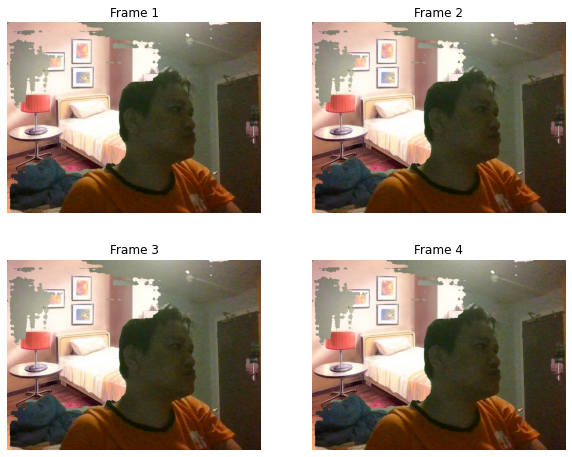

In [5]:
count = 0
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(myframes[count], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    count = count + 1

plt.show()